# Part 2

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

In [484]:
def generate_data(m,n,winnow=False):
    if winnow:
        data = np.random.randint(2, size=(m,(n+1)))
        data = np.sign(data)
    else:
        data = np.random.uniform(low=-1, high=1, size=(m,(n+1)))
        data = np.sign(data)
    x = data
    y = data[:,0]
    return x,y

def generate_data_winnow(m,n):
    data = np.random.randint(2, size=(m,(n+1)))
    data = np.sign(data)
    return data

def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias

## Binary Perceptron

In [537]:
# Binary perceptron algorithm 
# Learning rate? 
def perceptron_train(x,y,max_epoch=20, tol=0.01, learning_rate=1,random_select=False):
    m_train = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    x = add_bias(x)
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m_train)
    W = np.zeros(n+1)
    
    num_errors = 0 
    
    if random_select:
        max_epoch =1
        m = np.random.randint(low=0, high=m_train) #select random number of times to train the perceptron. 
    else:
        m = m_train
        
    for epoch in range(max_epoch):
        #print('epoch=',epoch)
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            x_t = x[t,:]
            y_t = y[t]
            pred_t = np.sign(W@x_t) #0 to begin with 
    
            if pred_t*y_t<=0:
                #print('t=',t)
                #print('error! y_lab=', y_t)
                num_errors +=1
                W = W + learning_rate*x_t.T*y_t
                errors[t] = num_errors 
                #print('W=',W)
                
        error_per_epoch[epoch] = num_errors
        #print(epoch, 'error=',errors[-1])
        
        #print('current_error_rate', error_per_epoch)
        
        if epoch>1:
            #print('old_error=',error_per_epoch[epoch-1])
            #print('new_error=',error_per_epoch[epoch])
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
 
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                print('error rate< 10%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')
                    break
        
    return W, error_per_epoch[:epoch+1]


def perceptron_test(x_test,y_test,W):
    x_test = add_bias(x_test)
    m_test = x_test.shape[0]
    pred = np.sign(x_test@W) #(n,1) x (m_test,n)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])   
    return mistakes,pred

In [409]:
x,y = generate_data(20,30)
W, error_per_epoch = perceptron_train(x,y,max_epoch=30, tol=0.01, learning_rate=1)

error rate< 10%
no error


In [132]:
mistakes,pred = perceptron_test(x[:10],y[:10],W)

In [410]:
error_per_epoch
### Does not seem to converge for some combination of x and y. 

array([9., 3., 0.])

## Winnow

In [478]:
def winnow_train(x,y,max_epoch=20,tol=0.01, learning_rate=1):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    W = np.ones(n)
    #x = add_bias(x)
    gamma_bound = n/2
    mistake_bound = (n/gamma_bound)**2
    #print(mistake_bound)
    num_errors = 0 
    
    #for epoch in range(max_epoch):
    epoch = 0
    while epoch < max_epoch:   
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
        #print('epoch=',epoch)
        #iterate through training set
        for t in range(m):
            
            x_t = x[t,:]
            y_t = y[t]
            gamma = W@x_t
            
            if gamma>= gamma_bound:
                pred_t = 1
            else:
                pred_t = 0
            
            if pred_t != y_t:
#                 print('error!')
                #print('pred=',pred_t)
#                 print('y_t=',y_t)
                num_errors+=1
                #print('x_t=',x_t)
                #print('y_t=',y_t)
                power = (y_t - pred_t)*x_t/1.0 #1 when error made on positive class, -1 when error made on negative class
                #print('ratio of update of W',power)
                W = W*(2**power) #element wise multiplication, and element wise power
                #print('W=',W)
                #Once weight>n, it should no longer change. 
                W[W>n] = n
#                 print(W)
                errors[t] = num_errors
#                 print('current error',num_errors)
                #print('W=',W)
                
        error_per_epoch[epoch] = num_errors
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            #print("Error rate is now ", error_per_epoch[epoch]/m )
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if error_per_epoch[epoch]/m < 0.05:
                #print('error rate< 5%')
                if diff_rates<tol:
                    print('converging')
                    break
                elif diff_rates<0:
                    print('error increased')
                    break
                elif error_per_epoch[epoch]==0:
                    print('no error')  
                    break
        epoch += 1
    return W, error_per_epoch[:epoch+1]


def winnow_test(x_test,y_test,W):
    m_test = x_test.shape[0]
    n = x_test.shape[1]
    gamma = x_test@W
    pred = np.zeros(m_test)
    pred[gamma>=n/2] = 1
    diff = pred - y_test
    mistakes = len(diff[diff!=0])  
    return mistakes,pred

In [481]:
x,y = generate_data(40,20,winnow=True)
W, error_per_epoch = winnow_train(x,y,max_epoch=15,tol=0.01, learning_rate=1)
mistakes,pred = winnow_test(x[:20],y[:20],W)
mistakes

converging


0

In [ ]:
# Least Squares Regression

In [ ]:
# 1 Nearest Neighbors

## Estimate Sample Complexity

Justifying the choice of sample size: when n < log_2(1000), there is a possbility that the sample contains all possible combinations of n agents' outcomes. Igore this 

In [558]:
#Compute by brute force, the sample complexity of each training algorithms
#Might derive a lower bound for m for a fixed n. Refer to lecture notes. 

def estimate_sample_complexity(max_m,max_n,function_choice):
    sample_complexity = np.zeros(max_n)
    
    for n in np.arange(1,max_n):
        test_size = min(2**n, 10000) #research for a better test size, curse of dimensionality
        #m_lower_bound = lower_bound_m(n,function_choice)
        min_m_per_run = np.zeros(20) #stores the minimum m found each run. 
        
        #Repeat for 20 runs. 
        for run in range(20):
            found_minimum_m=False 
            m = max(1, n-30) #initialize m. 
            
            #Iterate through increasing values of m. 
            while found_minimum_m==False:
                if function_choice=='winnow':
                    x,y = generate_data(m,n,True)
                    W, _ = winnow_train(x,y,max_epoch=1,tol=0.01, learning_rate=1)
                    x_test,y_test = generate_data(test_size,n,True)
                    test_mistakes,_ = winnow_test(x_test,y_test,W)

                elif function_choice == 'perceptron':
                    x,y = generate_data(m,n)
                    W, _ = perceptron_train(x,y,max_epoch=1, tol=0.01, learning_rate=1,random_select=True)
                    x_test,y_test = generate_data(test_size,n)
                    test_mistakes,_= perceptron_test(x_test,y_test,W)
                    
                    
                #Generalisation error is upper bound of training mistakes over total number of observations in D
                gen_error = (1.0/test_size) * test_mistakes
                
                if gen_error<0.1:
                    #print('n=',n, ' run=',run, ' min m=',m)
                    min_m_per_run[run] = m
                    found_minimum_m = True
                else:
                    m +=1

        sample_complexity[n] = min_m_per_run.mean()
        
    return sample_complexity

In [555]:
sample_complexity = estimate_sample_complexity(50,50,'winnow')

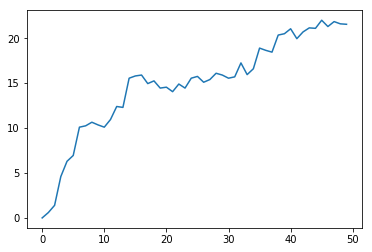

In [556]:
plt.plot(sample_complexity)

In [559]:
sample_complexity_p = estimate_sample_complexity(20,20,'perceptron') #a bit slower, for some reason. 

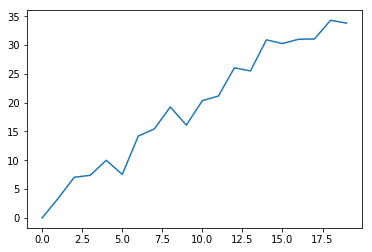

In [560]:
plt.plot(sample_complexity_p)

In [ ]:
## Could potentially use Binary search method

In [ ]:
#m <= nplog(H_size/delta)/epsilon
#H_size restricted on S <= 2^m 